In [1]:
import pandas as pd

print(f"{'pandas':<11} {pd.__version__:<6}")

import numpy as np

print(f"{'numpy':<11} {np.__version__:<6}")

import plotly

print(f"{'plotly':<11} {pd.__version__:<6}")

import matplotlib
import matplotlib.pyplot as plt
print(f"{'matplotlib':<11} {matplotlib.__version__:<6}")

import itertools

from adtk import __version__ as adtk_version

print(f"{'adtk':<11} {adtk_version:<6}")

from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import QuantileAD
from adtk.detector import InterQuartileRangeAD
from adtk.detector import PersistAD
from adtk.detector import LevelShiftAD
from adtk.detector import VolatilityShiftAD
from adtk.detector import SeasonalAD
from adtk.detector import AutoregressionAD
from adtk.detector import MinClusterDetector
from adtk.detector import OutlierDetector
from adtk.detector import PcaAD
from adtk.detector import GeneralizedESDTestAD
from sklearn.svm import OneClassSVM


from adtk.data import validate_series
from adtk.visualization import plot

from sklearn import __version__ as sklearn_version

print(f"{'sklearn':<11} {sklearn_version:<6}")
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import KMeans

from io import StringIO
from datetime import datetime, timedelta
from typing import List, Dict
# from support.convertion import load_conversion_from
# from support.parsers import p2f
# from support.parsers import d2d

# plt.rcParams["figure.figsize"] = [14, 10]
# plt.style.use("ggplot")

%matplotlib inline
%load_ext autoreload
%autoreload 2

pandas      1.1.3 
numpy       1.19.1
plotly      1.1.3 
matplotlib  3.3.1 
adtk        0.6.2 
sklearn     0.23.2


<AxesSubplot:title={'center':'Dist'}>

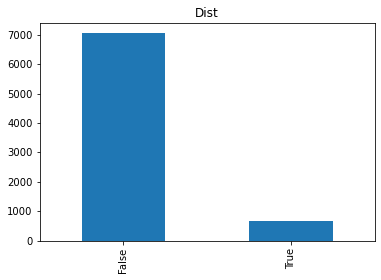

In [4]:
df0: pd.DataFrame = pd.read_csv(
    "traffic_AR_CL_UY+features+column_classifier.csv",
    parse_dates=["Fecha"]
)

df0["Fecha"] = pd.to_datetime(df0["Fecha"], utc=True)

df0["anomaly"].value_counts().plot(kind='bar', 
                                     title='Dist')

In [5]:
import plotly.graph_objects as go


def anomaly_plot(
    ts=None, anomaly=None, anomaly_color: str = "red", mode: str = "markers", title=""
):

    df: pd.DataFrame = None
    anomalies: pd.DataFrame = None

    if ts is not None:
        # type check for ts
        if isinstance(ts, pd.Series):
            if ts.name is None:
                df = ts.to_frame("Time Series")
            else:
                df = ts.to_frame()
        elif isinstance(ts, pd.DataFrame):
            df = ts.copy()
        else:
            raise TypeError("Argument `ts` must be a pandas Series or DataFrame.")

        # check series index
        if not isinstance(df.index, pd.DatetimeIndex):
            raise TypeError(
                "Index of the input time series must be a pandas "
                "DatetimeIndex object."
            )

        # check duplicated column names
        if df.columns.duplicated().any():
            raise ValueError("Input DataFrame must have unique column names.")

    else:  # no time series, just event
        df = pd.DataFrame(dtype=int)

    # plot anomaly
    if anomaly is not None:
        pass
    else:
        raise ValueError("Anomaly values should be provided")

    if isinstance(anomaly, pd.Series):

        anomaly: pd.Series = anomaly
        idx: pd.DatetimeIndex = anomaly[anomaly == True].index

        if anomaly.name in df.columns:
            anomalies: pd.DataFrame = df.loc[idx][anomaly.name].to_frame()
        else:
            anomalies: pd.DataFrame = df.loc[idx]
    elif isinstance(anomaly, pd.DataFrame):
        anomaly: pd.DataFrame = anomaly
        anomalies: pd.DataFrame = pd.DataFrame(columns=df.columns)
        for anomaly_name in anomaly.columns:
            if anomaly_name in df.columns:
                anomalies = pd.concat(anomalies, df.loc[anomaly[anomaly_name] == True])

    fig = go.Figure()

    for column_name in df.columns:
        # Add scatter trace for line
        fig.add_trace(
            go.Scatter(x=df.index, y=df[column_name], mode="lines", name=column_name)
        )
    for column_name in anomalies.columns:
        fig.add_trace(
            go.Scatter(
                x=anomalies.index,
                y=anomalies[column_name],
                mode="markers",
                marker=dict(
                    color="LightSkyBlue",
                    size=6,
                    opacity=0.5,
                    line=dict(color="red", width=2),
                ),
                showlegend=False,
            ),
        )
    fig.update_layout(
        title={"text": title,}
    )
    fig.show()

In [6]:
# Model Evaluation
from sklearn.metrics import confusion_matrix

def confusion_matrix_plot( Y_test, Y_preds ):

    conf_mat = confusion_matrix(Y_test, Y_preds)
    print(conf_mat)
    with plt.style.context(('ggplot', 'seaborn')):
        fig = plt.figure(figsize=(6,6), num=1)
        plt.imshow(conf_mat, interpolation='nearest',cmap= plt.cm.Blues )
        plt.xticks([0,1],[0,1])
        plt.yticks([0,1],[0,1])
        plt.xlabel('Predicted Label')
        plt.ylabel('Actual Label')
        for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
                    plt.text(j, i,conf_mat[i, j], horizontalalignment="center",color="red")
        plt.grid(None)
        plt.title('Confusion Matrix')
        plt.colorbar()
        plt.show()

In [7]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

def print_report( Y_test, Y_preds ):
    print('Precision                                   : %.3f'%precision_score(Y_test, Y_preds))
    print('Recall                                      : %.3f'%recall_score(Y_test, Y_preds))
    print('F1-Score                                    : %.3f'%f1_score(Y_test, Y_preds))
    print('\nPrecision Recall F1-Score Support Per Class : \n',precision_recall_fscore_support(Y_test, Y_preds))
    print('\nClassification Report                       : ')
    print(classification_report(Y_test, Y_preds))

A continuación se eligen los valores con los cuales se va a trabajar. Para continuar con el análisis realizado en trabajos anteriores, se continua trabajando con el sitio Mercado Libre Argentina, el flujo de compra directo y dos dispositivos: Android y Desktop.

In [8]:
sites: List[str] = list(df0["Site"].unique())[0]
flows: List[str] = list(df0["flow"].unique())[1]
devices: List[str] = list(df0["Device"].unique())[0:2]
    
print(sites)
print(flows)
print(devices)


MLA
direct
['Android', 'Desktop']


Para este análisis, se trabajó con una serie que contempla el mismo período de tiempo que se venía trabajando. Intenta reflejar el comportamiento de la Tasa de Conversión a lo largo del tiempo. La Tasa de Conversión, hace referencia a la cantidad de usuarios que ingresan al sitio y pasan de ser usuarios potenciales a usuarios ciertos. 

Con esto presente, en este análisis se probaron diversos modelos de detección de outliers o anomalías bajo métodos no supervisados. Se graficaron los resultados para cada uno de ellos y haciendo uso del conocimiento de dominio y los análisis anteriores sobre la serie, se eligió el modelo que se entiende refleja mas correctamente la cantidad de outliers que contiene la serie. 

In [19]:
#Agregar los códigos para demostrar que diferentes modelos muestran diferentes cosas: cambios de tendencia, etc.
#Comentar que si bien la accuracy es alta en todos los modelos, esto es porque el dataset está sesgado. Por esto, es mejor
#mirar precision, recall y F1.

El modelo elegido se trata de Isolation Forest. Isolation Forest es un algoritmo de aprendizaje automático basado en Árbol de Decisión. Eĺ modelo Isolation Forest se obtiene al combinar múltiples isolation tree, cada uno entrenado con una muestra distinta generada por bootstrapping a partir de los datos originales. El valor predicho para cada observación es el número de divisiones promedio que se han necesitado para aislar dicha observación en el conjunto de árboles. Cuanto menor es este valor, mayor es la probabilidad de que se trate de una anomalía.

[[431   5]
 [ 13  39]]


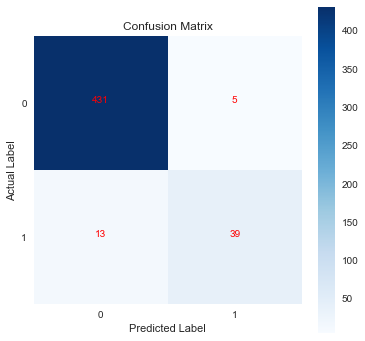

Precision                                   : 0.886
Recall                                      : 0.750
F1-Score                                    : 0.813

Precision Recall F1-Score Support Per Class : 
 (array([0.97072072, 0.88636364]), array([0.98853211, 0.75      ]), array([0.97954545, 0.8125    ]), array([436,  52], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

       False       0.97      0.99      0.98       436
        True       0.89      0.75      0.81        52

    accuracy                           0.96       488
   macro avg       0.93      0.87      0.90       488
weighted avg       0.96      0.96      0.96       488



[[424  15]
 [ 21  28]]


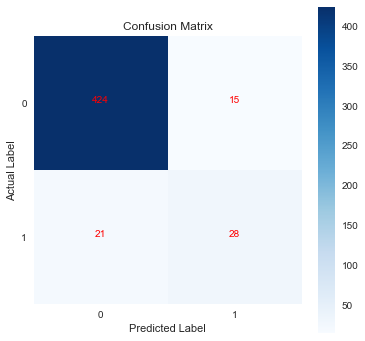

Precision                                   : 0.651
Recall                                      : 0.571
F1-Score                                    : 0.609

Precision Recall F1-Score Support Per Class : 
 (array([0.95280899, 0.65116279]), array([0.96583144, 0.57142857]), array([0.95927602, 0.60869565]), array([439,  49], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

       False       0.95      0.97      0.96       439
        True       0.65      0.57      0.61        49

    accuracy                           0.93       488
   macro avg       0.80      0.77      0.78       488
weighted avg       0.92      0.93      0.92       488



In [16]:
# criteria = [
#     (site, flow, device) for site in sites for flow in flows for device in devices
# ]

for (device) in devices:
    # print(f"⚪ Finding missing dates for  '({site},{flow})' on '{device}' ")

    result: pd.DataFrame = df0.query(
        f""" Site == 'MLA' and flow == 'direct' and Device == '{device}' """
    )
    if len(result.index) < 1:
        # print(f"🟢 No value found on '{site}' and flow '{flow}'\n")
        continue
        
    serie = result.set_index(["Fecha"])
    # Usaremos la conversion total como input
    s = serie["TOTAL"]
    s = validate_series(s)

#     quantile_ad = QuantileAD(high=0.98, low=0.05)
#     qad_anomalies = quantile_ad.fit_detect(s)
#     anomaly_plot(
#         s,
#         anomaly=qad_anomalies,
#         anomaly_color="red",
#         title=f" QuantileAD Plot for site MLA on flow direct and device {device}",
#     )
#     persist_ad = PersistAD(c=1.0, side='positive')
#     persist_ad.window = 100
#     anomalies = persist_ad.fit_detect(s)
#     anomalies = anomalies.fillna(0)
#     anomaly_plot(s, anomaly=anomalies, anomaly_color="red")

       
    # volatility_shift_ad = VolatilityShiftAD(c=2.5, side="both", window=14)
    # anomalies = volatility_shift_ad.fit_detect(s)
    # anomaly_plot(s, anomaly=anomalies, anomaly_color="red")

    # try:
    #    level_shift_ad = LevelShiftAD(c=3.0, side='both', window=14)
    #    sad_anomalies = level_shift_ad.fit_detect(s)
    #    anomaly_plot(
    #       s,
    #       anomaly=sad_anomalies,
    #       anomaly_color="red",
    #       title=f" Shift Anomaly Plot for site {site} on flow {flow} and device {device}",
    #   )   
    # except:
    #     print("An exception occurred")
    
    # esd_ad = GeneralizedESDTestAD(alpha=0.05)
    # esd_anomalies = esd_ad.fit_detect(s)
    # anomaly_plot(s, anomaly=esd_anomalies, anomaly_color="red")

    # autoregression_ad = AutoregressionAD(n_steps=7 * 2, step_size=3, c=3.0)
    # anomalies = autoregression_ad.fit_detect(s)
    # anomaly_plot(s, anomaly=anomalies, anomaly_color="red")

    # outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.17))
    outlier_detector = OutlierDetector(IsolationForest(contamination=0.09))
    #outlier_detector = OutlierDetector(EllipticEnvelope(contamination=0.11))

    od_anomalies = outlier_detector.fit_detect(s.to_frame())
    anomaly_plot(
       s,
       anomaly=od_anomalies,
       anomaly_color="red",
       title=f" OutlierDetector Plot for site MLA on flow direct and device {device}",
    )
    
#     min_cluster_detector = MinClusterDetector(KMeans(n_clusters=4))
#     anomalies = min_cluster_detector.fit_detect(s.to_frame())
#     anomaly_plot(s, anomaly=anomalies, anomaly_color="red",title=f" MinClusterDetector Plot for site {site} on flow {flow} and device {device}")

#     seasonal_ad = SeasonalAD(c=1.0, side="both")
#     anomalies = seasonal_ad.fit_detect(s)
#     anomaly_plot(s, anomaly=anomalies, anomaly_color="red")

#Combinación de dos modelos
#     od_anomalies = pd.DataFrame(od_anomalies) #elegir que combinar
#     qad_anomalies = pd.DataFrame(qad_anomalies) #elegir que combinar
#     mix = od_anomalies.join(qad_anomalies)
#     mix.columns

#     mix['max']=mix[[0, 'TOTAL']].max(axis=1)

    
    Y_test = serie["anomaly"]
    Y_preds = od_anomalies #PARA TIRAR LOS DOS JUNTOS HABRÍA QUE PONER mix['max']
    confusion_matrix_plot(Y_test, Y_preds)
    print_report(Y_test, Y_preds)

Probamos la combinación de dos modelos, para ver si se pueden mejorar los resultados: QuantileAD y OutlierDetector.

[[431   5]
 [ 13  39]]


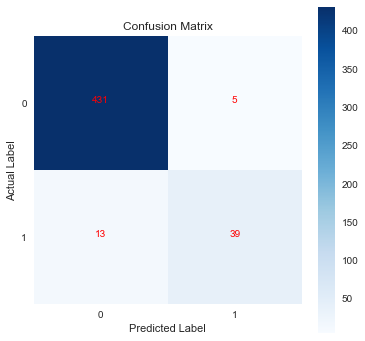

Precision                                   : 0.886
Recall                                      : 0.750
F1-Score                                    : 0.813

Precision Recall F1-Score Support Per Class : 
 (array([0.97072072, 0.88636364]), array([0.98853211, 0.75      ]), array([0.97954545, 0.8125    ]), array([436,  52], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

       False       0.97      0.99      0.98       436
        True       0.89      0.75      0.81        52

    accuracy                           0.96       488
   macro avg       0.93      0.87      0.90       488
weighted avg       0.96      0.96      0.96       488



[[429  10]
 [ 14  35]]


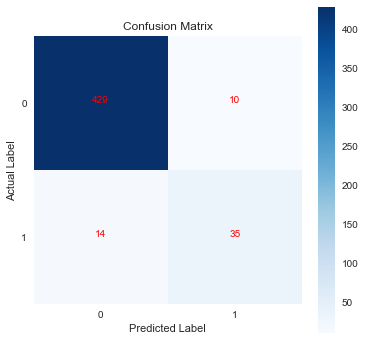

Precision                                   : 0.778
Recall                                      : 0.714
F1-Score                                    : 0.745

Precision Recall F1-Score Support Per Class : 
 (array([0.96839729, 0.77777778]), array([0.97722096, 0.71428571]), array([0.97278912, 0.74468085]), array([439,  49], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

       False       0.97      0.98      0.97       439
        True       0.78      0.71      0.74        49

    accuracy                           0.95       488
   macro avg       0.87      0.85      0.86       488
weighted avg       0.95      0.95      0.95       488



In [18]:
# criteria = [
#     (site, flow, device) for site in sites for flow in flows for device in devices
# ]

for (device) in devices:
    # print(f"⚪ Finding missing dates for  '({site},{flow})' on '{device}' ")

    result: pd.DataFrame = df0.query(
        f""" Site == 'MLA' and flow == 'direct' and Device == '{device}' """
    )
    if len(result.index) < 1:
        # print(f"🟢 No value found on '{site}' and flow '{flow}'\n")
        continue
        
    serie = result.set_index(["Fecha"])
    # Usaremos la conversion total como input
    s = serie["TOTAL"]
    s = validate_series(s)

    quantile_ad = QuantileAD(high=0.98, low=0.05)
    qad_anomalies = quantile_ad.fit_detect(s)
    anomaly_plot(
        s,
        anomaly=qad_anomalies,
        anomaly_color="red",
        title=f" QuantileAD Plot for site MLA on flow direct and device {device}",
    )
#     persist_ad = PersistAD(c=1.0, side='positive')
#     persist_ad.window = 100
#     anomalies = persist_ad.fit_detect(s)
#     anomalies = anomalies.fillna(0)
#     anomaly_plot(s, anomaly=anomalies, anomaly_color="red")

       
    # volatility_shift_ad = VolatilityShiftAD(c=2.5, side="both", window=14)
    # anomalies = volatility_shift_ad.fit_detect(s)
    # anomaly_plot(s, anomaly=anomalies, anomaly_color="red")

    # try:
    #    level_shift_ad = LevelShiftAD(c=3.0, side='both', window=14)
    #    sad_anomalies = level_shift_ad.fit_detect(s)
    #    anomaly_plot(
    #       s,
    #       anomaly=sad_anomalies,
    #       anomaly_color="red",
    #       title=f" Shift Anomaly Plot for site {site} on flow {flow} and device {device}",
    #   )   
    # except:
    #     print("An exception occurred")
    
    # esd_ad = GeneralizedESDTestAD(alpha=0.05)
    # esd_anomalies = esd_ad.fit_detect(s)
    # anomaly_plot(s, anomaly=esd_anomalies, anomaly_color="red")

    # autoregression_ad = AutoregressionAD(n_steps=7 * 2, step_size=3, c=3.0)
    # anomalies = autoregression_ad.fit_detect(s)
    # anomaly_plot(s, anomaly=anomalies, anomaly_color="red")

    # outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.17))
    outlier_detector = OutlierDetector(IsolationForest(contamination=0.09))
    #outlier_detector = OutlierDetector(EllipticEnvelope(contamination=0.11))

    od_anomalies = outlier_detector.fit_detect(s.to_frame())
    anomaly_plot(
       s,
       anomaly=od_anomalies,
       anomaly_color="red",
       title=f" OutlierDetector Plot for site MLA on flow direct and device {device}",
    )
    
#     min_cluster_detector = MinClusterDetector(KMeans(n_clusters=4))
#     anomalies = min_cluster_detector.fit_detect(s.to_frame())
#     anomaly_plot(s, anomaly=anomalies, anomaly_color="red",title=f" MinClusterDetector Plot for site {site} on flow {flow} and device {device}")

#     seasonal_ad = SeasonalAD(c=1.0, side="both")
#     anomalies = seasonal_ad.fit_detect(s)
#     anomaly_plot(s, anomaly=anomalies, anomaly_color="red")

#ACA COMBINO LOS DOS
    od_anomalies = pd.DataFrame(od_anomalies) #elegir que combinar
    qad_anomalies = pd.DataFrame(qad_anomalies) #elegir que combinar
    mix = od_anomalies.join(qad_anomalies)
    mix.columns

    mix['max']=mix[[0, 'TOTAL']].max(axis=1)

    
    Y_test = serie["anomaly"]
    Y_preds = mix['max'] #PARA TIRAR LOS DOS JUNTOS HABRÍA QUE PONER mix['max']
    confusion_matrix_plot(Y_test, Y_preds)
    print_report(Y_test, Y_preds)

Como puede observarse, para el caso del device Android los resultados no cambian, pero para el caso de Desktop, mejoran.

In [21]:
#Comentar que se debería probar la combinación de dos modelos, uno que permita encontrar los outliers que escapan 
#de la media, por ejemplo, y otro que permita anticiparse a los cambios de tendencia.
